In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Settings

In [2]:
# Parameters
k = 1.
CM = 1.
tend = 0.02 # 60

# Initial distribution
nmax = 120
i0 = 100
iwidth = 10
x = np.arange(0, nmax+1)
P0 = np.zeros_like(x)
P0[i0+1:i0+1+iwidth] = 1.

## Population balance equations

In [3]:
# ODEs to be solved
def ode_propagation(_, P):
    "P(n) + M -> P(n+1)"
    Pleft = np.empty_like(P)
    Pleft[0] = 0.
    Pleft[1:] = P[:-1]
    Pdot = k*CM*(Pleft - P)
    return Pdot

def ode_depropagation(_, P):
    "P(n) -> P(n-1) + M"
    Pright = np.empty_like(P)
    Pright[-1] = 0.
    Pright[:-1] = P[1:]
    Pdot = k*(Pright - P)
    return Pdot

def ode_combination(_, P):
    "P(n) + P(m) -> P(n+m)"
    # Source term
    Pplus = np.zeros_like(P)
    for n in range(2, P.size):
        accum = 0.
        for i in range(1, n):
            accum += P[i]*P[n-i]
        Pplus[n] = accum
    Pplus *= 0.5
    # Sink term
    Pminus = P*np.sum(P)
    Pdot = k*(Pplus - Pminus)
    return Pdot

def ode_scission(_, P):
    "P(n) -> P(n-m) + P(m)"
    # Source term
    Pplus = np.zeros_like(P)
    # for n in range(1, len(Pplus)):
    #     Pplus[n] = np.sum(P[n+1:])
    Pplus[1:-1] = np.cumsum(P[2:][::-1])[::-1]
    Pplus *= 2
    # Sink term
    Pminus = (x - 1)*P
    Pminus[0] = 0
    Pdot = k*(Pplus - Pminus)
    return Pdot

## ODE Solution

In [4]:
ode = ode_scission
teval = np.linspace(0, tend, 100)
solution = solve_ivp(ode,
                     t_span=(0, tend),
                     y0=P0,
                     t_eval = teval,
                     method='RK45',
                     rtol=1e-5,
                    )

# Unpack results
t = solution.t
P = solution.y

## Plots

### Full distribution

Text(0, 0.5, 'Number of chains')

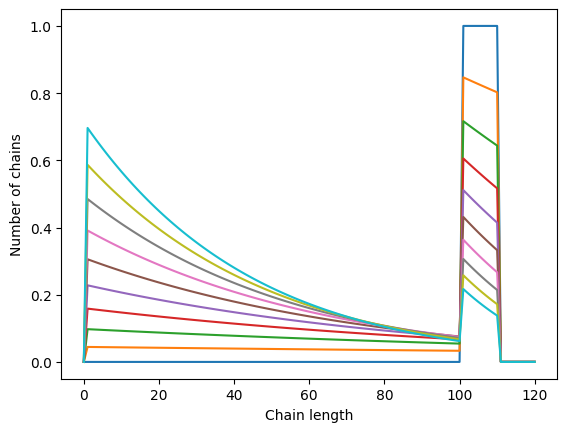

In [5]:
fig, ax = plt.subplots()
for i in range(0, len(t), round(len(t)/10)):
    label = f"t={t[i]}"
    ax.plot(x, P[:,i], label=label) # x*P[:,i]
ax.set_xlabel("Chain length")
ax.set_ylabel("Number of chains")

### Moments

Text(0.5, 0, 'Time')

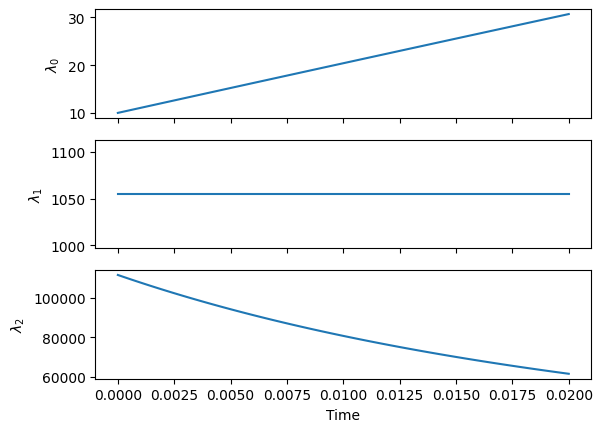

In [6]:
def moment_numerical(order, P):
    "Numerical moment of distribution P(n)."
    return np.sum((x[:, np.newaxis]**order)*P, 0)

orders = [0, 1, 2]
fig, ax = plt.subplots(len(orders), sharex=True)
for i, order in enumerate(orders):
    m = moment_numerical(order, P)
    ax[i].plot(t, m, label='numerical')
    ax[i].set_ylabel(rf"$\lambda_{i}$")
    # m = moment_analytical(order, t)
    # ax[i].plot(t, m, label='analytical')
# ax[0].legend(loc="lower left")
ax[-1].set_xlabel("Time")
